In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

os.chdir("/content/gdrive/My Drive/CoverMyMeds Project")

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("pharmacy_tx.csv")

First, we drop all rows with missing values

In [ ]:
df_noNaN = df.dropna()

Check whether rejected = 0 means that co-pay = 0

In [ ]:
rejected_copay = df.loc[df.rejected == True,'patient_pay']

print("Minimum co-pay among rejected is:")
print(rejected_copay.min())
print("Maximum co-pay among rejected is:")
print(rejected_copay.max())

Minimum co-pay among rejected is:
0.0
Maximum co-pay among rejected is:
0.0


Keep only rows for which rejected = False

In [ ]:
df_copay = df_noNaN.loc[df_noNaN.rejected == False, :]

Is there a 1-1 correspondence between pcn and group for a fixed bin? We check in the code below.

In [ ]:
# check how many unique pcns there are for a fixed bin, group

bin_group = df_copay.groupby(['bin','group'])['pcn'].agg([('pcnCtUnique','nunique')]).reset_index()
print("Minimum number of unique pcn counts among bin-group segments:")
print(bin_group.pcnCtUnique.min())
print("Maximum number of unique pcn counts among bin-group segments:")
print(bin_group.pcnCtUnique.max())


Minimum number of unique pcn counts among bin-group segments:
1
Maximum number of unique pcn counts among bin-group segments:
1


In [ ]:
# check how many unique groups there are for a fixed bin, pcn

bin_pcn = df_copay.groupby(['bin','pcn'])['group'].agg([('grpCtUnique','nunique')]).reset_index()
print("Minimum number of unique group counts among bin-pcn segments:")
print(bin_pcn.grpCtUnique.min())
print("Maximum number of unique group counts among bin-pcn segments:")
print(bin_pcn.grpCtUnique.max())

Minimum number of unique group counts among bin-pcn segments:
1
Maximum number of unique group counts among bin-pcn segments:
1


This suggests that there is a 1-1 correspondence between group and pcn. Action: if both group and pcn are missing, we should drop the row. Otherwise, we can just fill the missing with "NA".

In [ ]:
# remove rows where both are NaN

df_noNaN = df.dropna(subset=['group', 'pcn'], how='all')
df_noNaN.fillna("NA", inplace = True)
df_copay = df_noNaN.loc[df_noNaN.rejected == False, :]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Check that there are no duplicates in the data set

In [ ]:
print("Number of rows in original data set:")
print(len(df_copay))

df_copay.drop_duplicates(inplace=True)

print("Number of rows in original data set:")
print(len(df_copay))


Number of rows in original data set:
12787748
Number of rows in original data set:
11476919


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Is it possible for 2 different bins to have the same group?

In [ ]:
group_bin = df_copay.groupby(['group','bin'])['bin'].agg([('binCtUnique','nunique')]).reset_index()
group_bin.head()

,group,bin,binCtUnique
0,0OGKQ,664344,1
1,0TZ9XYJZJH,322463,1
2,1CAHL,539437,1
3,1N5IRQ,664344,1
4,52H8KH0F83K,664344,1


In [ ]:
group_bin.binCtUnique.max()
group_bin.binCtUnique.sum()
len(df_copay.bin.unique())

12

Now, we combine bin, group, and pcn as a single identifier. We then try to segment the data according to this identifier and count the number of samples in each segment.

In [ ]:
# add new column by combining bin, pcn, group

df_copay['bin_pcn_group'] = df_copay.bin.astype('str') + '_' + df_copay.pcn.astype('str') + '_' + df_copay.group.astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#%% now do segmentation and count how many samples per segment

segment_count = df_copay.groupby('bin_pcn_group')['bin_pcn_group'].agg([('NSamples','count')]).reset_index()
print("Minimum number of samples across all segments is:")
print(segment_count.NSamples.min())
print("Maximum number of samples across all segments is:")
print(segment_count.NSamples.max())

print("The number of segments is:")
print(len(segment_count))

Minimum number of samples across all segments is:
10575
Maximum number of samples across all segments is:
1013106
The number of segments is:
62


Seems like we have enough samples per segment. But for a fixed segment, do we have enough samples per drug?

In [ ]:
# now do segmentation by the number of drugs per segment

drug_in_segment = df_copay.groupby(['bin_pcn_group','drug'])['drug'].agg([('DrugCt','count')]).reset_index()
print("Minimum number of samples of a drug across all segments is:")
print(drug_in_segment.DrugCt.min())
print("Maximum number of samples of a drug across all segments is:")
print(drug_in_segment.DrugCt.max())

Minimum number of samples of a drug across all segments is:
1
Maximum number of samples of a drug across all segments is:
67717


Maybe if we extract the brand name of the drug, we would get more samples for each drug.

In [ ]:
# split up brand and drug

def drug_parts(d):
    return d.split(' ')[0], d.split(' ')[1]

df_copay['drug_brand'], df_copay['drug_name'] = zip(*df_copay['drug'].astype('str').map(drug_parts))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# now do segmentation by the number of drug names per segment

drugname_in_segment = df_copay.groupby(['bin_pcn_group','drug_name'])['drug_name'].agg([('DrugCt','count')]).reset_index()
print("Minimum number of samples of a drug across all segments is:")
print(drugname_in_segment.DrugCt.min())
print("Maximum number of samples of a drug across all segments is:")
print(drugname_in_segment.DrugCt.max())

print(drugname_in_segment.sort_values(by='DrugCt').head())

Minimum number of samples of a drug across all segments is:
1
Maximum number of samples of a drug across all segments is:
132955
                   bin_pcn_group     drug_name  DrugCt
1403  664344_AZUO5U_IGN6JL34H37D     nenizevir       1
1170          571569_NA_7LL04USF     lehydrome       1
633              322463_ULM7G_NA  gentipapavir       1
4115       725700_OO0E_HPVSQW7M8       devacin       2
1556            664344_CS8580_NA     nenizevir       3


If we fix the drug and insurance identifier, is there a variation in the co-pay?

In [ ]:
drug_insuranceInfo = df_copay.groupby(['drug','bin_pcn_group'])['patient_pay'].agg([('MinPay','min'),('MaxPay','max')]).reset_index()
print(drug_insuranceInfo.head(10))

              drug           bin_pcn_group  MinPay  MaxPay
0  branded antimab   160389_RB7UU_RS5RB3YA   19.25   22.04
1  branded antimab     322463_393U_XY5GQQ9   18.72   21.22
2  branded antimab       322463_3O71UTS_NA   18.43   21.22
3  branded antimab        322463_3Y5ZW0_NA   21.34   24.10
4  branded antimab  322463_9FU70_U19J4RVCA   32.98   35.77
5  branded antimab    322463_NA_0TZ9XYJZJH   19.02   42.85
6  branded antimab       322463_NA_HO8HUGL    6.20    6.20
7  branded antimab     322463_T52GV_EVD4X5    6.23    6.23
8  branded antimab         322463_ULM7G_NA   18.43   21.22
9  branded antimab     322463_YICC41_MP3IQ   20.08   42.85


We plot a histogram of co-pay to see the range of values.

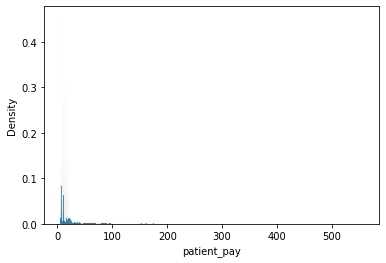

In [ ]:
import seaborn as sns
sns.histplot(data=df_copay, x = "patient_pay", stat = "density")

In [ ]:
print(df_copay["patient_pay"].max())
print(df_copay["patient_pay"].min())

557.93
3.4


In [ ]:
drugname_segment = df_copay.groupby(['drug_name','bin_pcn_group'])['bin_pcn_group'].agg([('planCount','count')]).reset_index()
print("Minimum number of samples of a health plan across all segments is:")
print(drugname_segment.planCount.min())
print("Maximum number of samples of a health across all segments is:")
print(drugname_segment.planCount.max())


Minimum number of samples of a health plan across all segments is:
1
Maximum number of samples of a health across all segments is:
132955


In [ ]:
print(drugname_segment.head(100))
print(len(drugname_segment))
print(drugname_segment['planCount'].sum())

   drug_name                bin_pcn_group  planCount
0    antimab        160389_RB7UU_RS5RB3YA       5863
1    antimab          322463_393U_XY5GQQ9        533
2    antimab            322463_3O71UTS_NA      15360
3    antimab             322463_3Y5ZW0_NA       2978
4    antimab       322463_9FU70_U19J4RVCA       1425
..       ...                          ...        ...
95   bovirol  664344_REGLCC_BH2Q8B3GY2GAV       1848
96   bovirol       664344_T17LNK_Z01MLD4I       2494
97   bovirol      664344_TAZ5W_T51T6V2E8L       2511
98   bovirol               664344_TPJD_NA       3298
99   bovirol          664344_W1LW9Y_0OGKQ       1666

[100 rows x 3 columns]
4713
12787748


We try to see if we can do segmentation according to the drug. We will compute the max, min, and average copay for each drug.



In [ ]:
drugVSPay = df_copay.groupby(['drug_name'])['patient_pay'].agg([('Max','max'),('Min','min'),('Mean','mean')]).reset_index()
drugVSPay.sort_values(by=['Mean'],ascending=False,inplace=True)

In [ ]:
print(drugVSPay.head(50))

          drug_name     Max    Min        Mean
41      monemodiase  557.93  15.02  405.652134
49       pheromycin  485.65  15.02  366.764147
53   prefluflomycin  359.85  15.02  231.264940
17   flacelfatastat  321.12  15.02  204.620581
39          masonic  328.69  15.02  203.098863
51           pranic  265.99  15.02  168.194101
74        tugesutin  261.19  15.02  161.189034
75       vivafastat  227.62  15.02  150.706585
21   genetramycicin  219.30  15.02  136.862242
13         diadaric  205.34  15.02  124.721377
12          devacin  181.27  15.02  123.968117
3    choxestamenium  188.02  15.02  123.916842
47        nusudaric  197.24  15.02  119.288760
11           debome  181.90  15.02  111.410691
46            notin  170.31  15.02  108.880859
44       nephelilin  139.66  15.02   86.929870
28           gosate  125.89  15.02   84.198981
43        nenizevir  111.53  16.29   77.468436
16        fazipilin  130.81   7.76   77.212799
18         flalurin   97.39  15.02   72.098450
9           c

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <a list of 10 Text major ticklabel objects>)

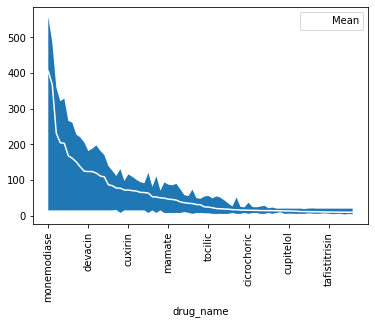

In [ ]:
#drugVSPay.reset_index(inplace=True)
import matplotlib.pyplot as plt
ax  = drugVSPay.plot(x='drug_name', y='Mean', c='white')
plt.fill_between(x='drug_name',y1='Min',y2='Max', data=drugVSPay)
plt.xticks(rotation=90)

Extract rows corresponding to drug monemodiase and for which co-pay is large or small to see what other factors contribute to this copay.

In [ ]:
drug1_largepay = df_copay.loc[(df_copay.drug_name == 'monemodiase') & (df_copay.patient_pay > 500),['tx_date','pharmacy','diagnosis','drug_brand','drug_name','bin_pcn_group','patient_pay']].reset_index()
print(drug1_largepay)

          index     tx_date      pharmacy diagnosis drug_brand    drug_name  \
0           510  2022-01-02   Pharmacy #6    U75.95    branded  monemodiase   
1          2950  2022-01-02   Pharmacy #3    U75.95    branded  monemodiase   
2          3284  2022-01-02  Pharmacy #55    U75.95    branded  monemodiase   
3          5806  2022-01-02  Pharmacy #11    U75.95    branded  monemodiase   
4          5918  2022-01-02  Pharmacy #24    B45.03    branded  monemodiase   
...         ...         ...           ...       ...        ...          ...   
10079  13901386  2022-12-28  Pharmacy #55    B45.03    branded  monemodiase   
10080  13904984  2022-12-29   Pharmacy #9    B45.03    branded  monemodiase   
10081  13906108  2022-12-29  Pharmacy #26    U75.95    branded  monemodiase   
10082  13909780  2022-12-30  Pharmacy #33    B45.03    branded  monemodiase   
10083  13909851  2022-12-30  Pharmacy #20    U75.95    branded  monemodiase   

                    bin_pcn_group  patient_pay  
0 

In [ ]:
drug1_smallpay = df_copay.loc[(df_copay.drug_name == 'monemodiase') & (df_copay.patient_pay <16),['tx_date','pharmacy','diagnosis','drug_brand','drug_name','bin_pcn_group','patient_pay']].reset_index()
print(drug1_smallpay)

        index     tx_date      pharmacy diagnosis drug_brand    drug_name  \
0       39290  2022-01-04  Pharmacy #40    H33.06    branded  monemodiase   
1       44706  2022-01-04  Pharmacy #44    U75.95    branded  monemodiase   
2      122735  2022-01-07  Pharmacy #18    B45.03    branded  monemodiase   
3      130364  2022-01-07   Pharmacy #1    B45.03    branded  monemodiase   
4      145509  2022-01-07  Pharmacy #47    B45.03    branded  monemodiase   
..        ...         ...           ...       ...        ...          ...   
234  13757823  2022-12-23   Pharmacy #5    U75.95    branded  monemodiase   
235  13763616  2022-12-23   Pharmacy #1    U75.95    branded  monemodiase   
236  13821774  2022-12-24  Pharmacy #44    B45.03    branded  monemodiase   
237  13854758  2022-12-25  Pharmacy #50    B45.03    branded  monemodiase   
238  13895391  2022-12-27  Pharmacy #37    U75.95    branded  monemodiase   

               bin_pcn_group  patient_pay  
0      725700_OO0E_HPVSQW7M8   